In [1]:
import anndata as ad
import torch
import vapor
from vapor.config import VAPORConfig


/home/ubuntu/miniconda3/envs/vapor/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import anndata as ad
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

mpl.rcParams['pdf.fonttype'] = 42


# Train Model

In [3]:
# Load data
adata = ad.read_h5ad('../data/drugSeries.h5ad')
print(adata.obs.groupby('cell_line').size().sort_values())

# Count and log normalize
X = adata.X
X = 10_000 * X / X.sum(axis=1)
adata.X = X.log1p().tocsc()

# Filter data
# SEPARABLE: LUNG
# NOT SEPARABLE: OESOPHAGUS, CENTRAL_NERVOUS_SYSTEM, KIDNEY, OVARY (256)
# NOT WORKING: LARGE_INTESTINE, UPPER_AERODIGESTIVE_TRACT, URINARY_TRACT
valid_treatments = ['DMSO_48hr']
valid_treatments += [f'Tram_{i}hr' for i in (3, 6, 12, 24, 48)]  # Maybe hold out 24?
mask = adata.obs['treatment'].isin(valid_treatments)
mask *= adata.obs['cell_line'].isin(['LUNG', 'OESOPHAGUS', 'SKIN', 'CENTRAL_NERVOUS_SYSTEM', 'LARGE_INTESTINE'])
adata = adata[mask]

# Normalize
X = adata.X.toarray()
X_std = X.std(axis=0)
X = (X - X.mean(axis=0)) / np.where(X_std==0, 1, X_std)
adata = ad.AnnData(X, obs=adata.obs, var=adata.var)
gene_names = adata.var['gene_name']

# Reduce
red = sklearn.decomposition.PCA(n_components=512, random_state=42)
X_pca = red.fit_transform(adata.X)
adata_orig = adata
adata = ad.AnnData(X_pca, obs=adata.obs)

# Annotate timepoints
timepoint_dict = {k: v for k, v in zip(valid_treatments, (0, 3, 6, 12, 24, 48))}  # Should this be scaled?
adata.obs['Timepoint'] = adata.obs['treatment'].apply(lambda x: timepoint_dict[x])


/tmp/ipykernel_23551/2011026883.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(adata.obs.groupby('cell_line').size().sort_values())


cell_line
BILIARY_TRACT                 222
PROSTATE                      301
ENDOMETRIUM                   614
STOMACH                       665
OVARY                         750
BREAST                        752
URINARY_TRACT                 936
UPPER_AERODIGESTIVE_TRACT     978
KIDNEY                        999
LARGE_INTESTINE              1156
CENTRAL_NERVOUS_SYSTEM       1214
SKIN                         1276
OESOPHAGUS                   1574
LUNG                         2276
dtype: int64


In [4]:
# Create supervised dataset
root_indices = adata.obs.index[adata.obs['treatment'] == 'DMSO_48hr'].to_numpy()
terminal_indices = adata.obs.index[adata.obs['treatment'] == 'Tram_48hr'].to_numpy()
dataset = vapor.dataset_from_adata(
    adata,
    # root_where=['treatment=DMSO_48hr'],
    root_indices=root_indices,
    # terminal_where=['treatment=Tram_48hr'],
    terminal_indices=terminal_indices,
    time_label='Timepoint',
    # root_n=200, terminal_n=200, 
    # seed=42,
    scale=True)


Time Range: (0.000, 1.000)
Data scaled per row.


In [5]:
# Config
config = VAPORConfig(
    latent_dim=128, n_dynamics=10, lr=5e-4,
    beta=0.01, eta=1.0, t_max=4, 
    # epochs=500, batch_size=512,
    device='cuda')

# Initialize model
model = vapor.initialize_model(adata.n_vars, config=config)


Initializing model:
  Input dim: 512
  Latent dim: 128
  Encoder dims: [2048, 512, 128]
  Decoder dims: [128, 512, 2048]
  N dynamics: 10
0.5


In [6]:
# Find best lr
res = vapor.utils.lr_finder_vapor(
    model,
    dataset,
    beta = config.beta,
    batch_size = config.batch_size,
    num_steps = 500,
    lr_min = 1e-6,
    lr_max = 1e-2,
    device = config.device,
    save_plot = './plots/lr_finder.pdf',
)
config.lr=res.best_lr

[LR Finder] step    0 | lr=1.00e-06 | smoothed_loss=2.005
[LR Finder] step   50 | lr=2.52e-06 | smoothed_loss=1.987
[LR Finder] step  100 | lr=6.33e-06 | smoothed_loss=1.921
[LR Finder] step  150 | lr=1.59e-05 | smoothed_loss=1.802
[LR Finder] step  200 | lr=4.01e-05 | smoothed_loss=1.642
[LR Finder] step  250 | lr=1.01e-04 | smoothed_loss=1.393
[LR Finder] step  300 | lr=2.54e-04 | smoothed_loss=1.061
[LR Finder] step  350 | lr=6.39e-04 | smoothed_loss=0.8175
[LR Finder] step  400 | lr=1.61e-03 | smoothed_loss=0.681
[LR Finder] step  450 | lr=4.05e-03 | smoothed_loss=0.6069

[LR Finder] Done.
  lr_at_min_loss = 1.00e-02
  lr_at_diverge  = 1.00e-02 (diverged=False)
  suggested base_lr ≈ 5.00e-04  (rule: diverge/20)
Saved: ./plots/lr_finder.pdf


In [7]:
# Load model
# model.load_state_dict(torch.load('./trained_model.h5'))
# trained_model = model

# Train
trained_model = vapor.train_model(model, dataset, config=config)


Train / Test split: train=3568, test=892 (test_size=0.2)
overlap params: 0
Training (full-graph) for 250 epochs | batch=512 | steps/epoch=7
[Graph] Refreshing global kNN graph at epoch 0 (K=20) ...
[Graph] Done. z_all shape=(4460, 128), nbr_idx shape=(4460, 20)

Starting training...
--------------------------------------------------------------------------------
[LR] lr_vae=1.25e-04 lr_to=0.00e+00 (sched_to=0.000)
Epoch 1/250 | time 0.11s | Recon 1.8280 | KL 0.1283 | TrajSoft 0.0000 | Prior 0.0000 | phase=vae_only
Epoch 2/250 | time 0.05s | Recon 1.6073 | KL 0.1324 | TrajSoft 0.0000 | Prior 0.0000 | phase=vae_only
Epoch 3/250 | time 0.05s | Recon 1.5103 | KL 0.1410 | TrajSoft 0.0000 | Prior 0.0000 | phase=vae_only
Epoch 4/250 | time 0.05s | Recon 1.4300 | KL 0.1529 | TrajSoft 0.0000 | Prior 0.0000 | phase=vae_only
[Graph] Refreshing global kNN graph at epoch 5 (K=20) ...
[Graph] Done. z_all shape=(4460, 128), nbr_idx shape=(4460, 20)
[LR] lr_vae=1.25e-04 lr_to=0.00e+00 (sched_to=0.000)

In [8]:
# Save model
# torch.save(trained_model, './trained_model_large_intestine_logcountnorm.h5')
# vapor.utils.save_checkpoint(trained_model, config, './trained_model_large_intestine_logcountnorm.pt'))


# Visualize

## UMAPs

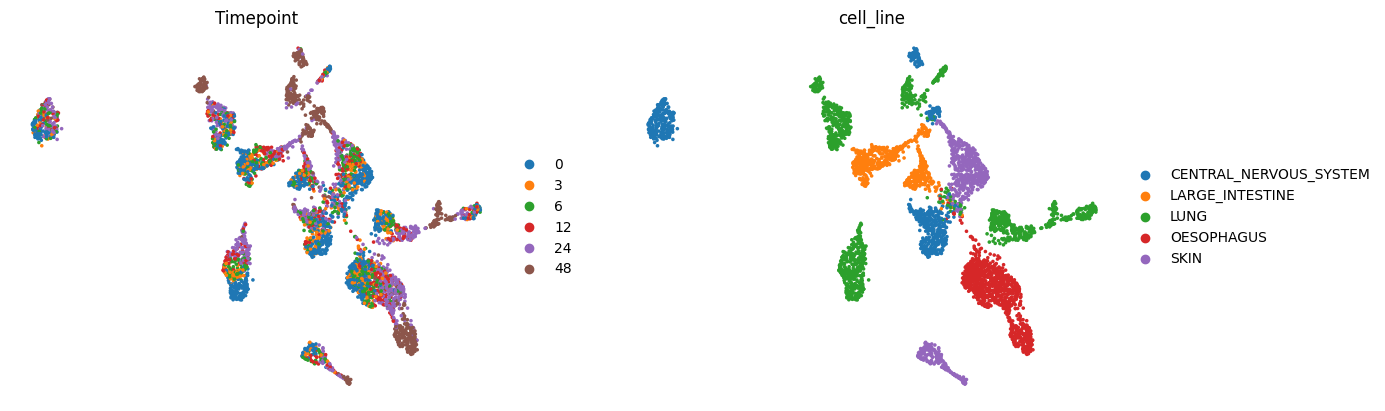

In [9]:
import scanpy as sc
from vapor.inference import extract_latents_and_dynamics
adata_VAPOR = extract_latents_and_dynamics(trained_model, adata, scale=True, device='cpu')

n_neighbors = 20  # 200 results in error
sc.pp.neighbors(adata_VAPOR, n_neighbors=n_neighbors, random_state=42, use_rep='X')
sc.tl.umap(adata_VAPOR)
fig = sc.pl.embedding(adata_VAPOR, basis='umap', color=['Timepoint', 'cell_line'], frameon=False, show=False, return_fig=True)
fig.savefig('./plots/umap.pdf')


computing velocity graph (using 1/8 cores)
or disable the progress bar using `show_progress_bar=False`.


    finished (0:00:01) --> added 
    'v_VAPOR_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'v_VAPOR_umap', embedded velocity vectors (adata.obsm)


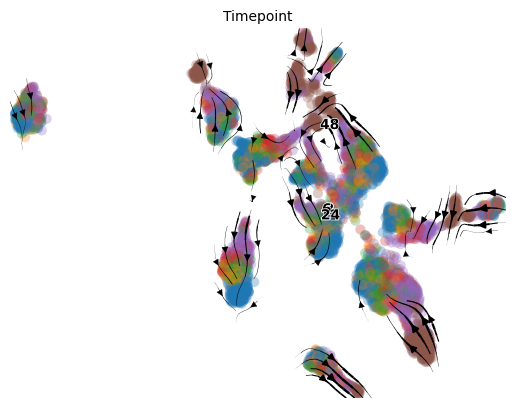

In [10]:
# TODO: Annotate cell line + time
import scvelo as scv
sc.pp.neighbors(adata_VAPOR,use_rep='X_VAPOR', random_state=42, n_neighbors=n_neighbors)
scv.tl.velocity_graph(adata_VAPOR, vkey='v_VAPOR', xkey='vapor')
ax = scv.pl.velocity_embedding_stream(adata_VAPOR, vkey='v_VAPOR', basis='umap', color=['Timepoint'], show=False)
ax.get_figure().savefig('./plots/velo.svg')


## Clusters

In [11]:
# # Get UMAP
# X = adata_VAPOR.obsm['X_umap']
# clust = sklearn.cluster.KMeans(n_clusters=7)
# X_clust = clust.fit_predict(X)


In [12]:
# # Plot
# fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# sep = adata.obs['cell_line']
# for c in np.unique(sep):
#     X_filt = X[sep==c]
#     ax.scatter(*X_filt.T, label=c)
# ax.legend()


In [13]:
# # Plot
# fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# sep = X_clust
# for c in np.unique(sep):
#     X_filt = X[sep==c]
#     ax.scatter(*X_filt.T, label=c)
# ax.legend()


In [14]:
# # Genes by cluster
# df = pd.DataFrame(adata_orig.X, columns=adata_orig.var_names)
# df['cluster'] = X_clust
# cluster_diff = df.groupby('cluster').mean()
# cluster_mean_diff = cluster_diff - cluster_diff.mean(axis=0)
# max_genes_idx = np.argsort(cluster_mean_diff.abs(), axis=1)[:, ::-1]
# max_genes = (
#     adata_orig.var['gene_name'].to_numpy()
#     [max_genes_idx.flatten()]
#     .reshape(max_genes_idx.shape))
# max_genes[:, :5]


## Components

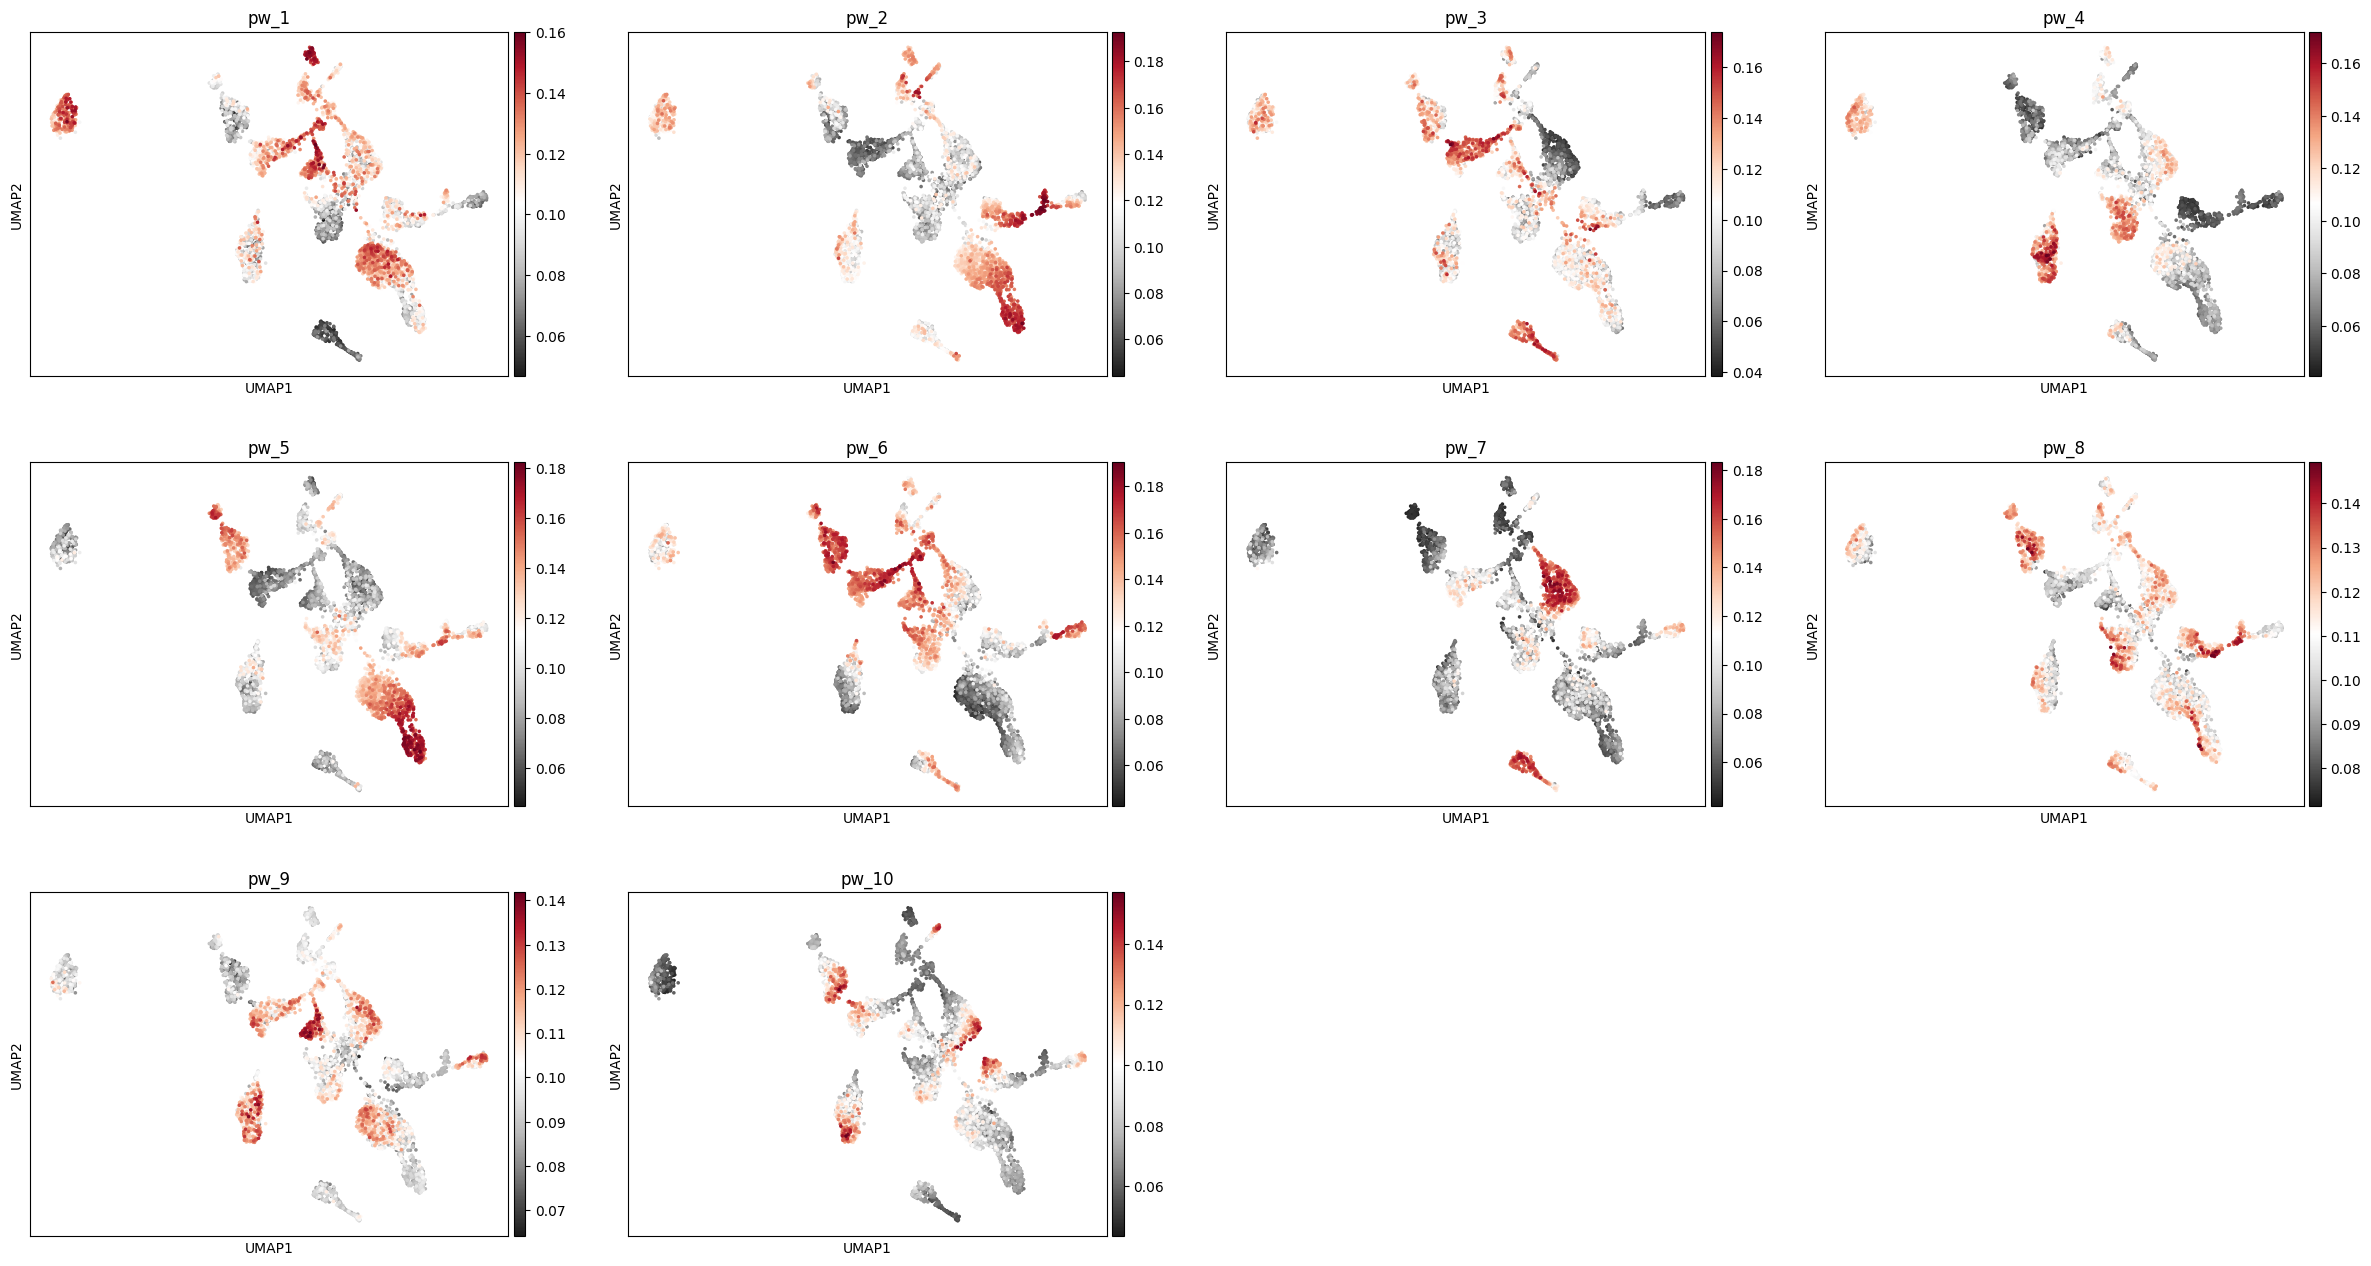

In [15]:
n_dynamics = model.transport_op.n_dynamics
fig = sc.pl.embedding(
    adata_VAPOR,
    color=[f"pw_{i+1}" for i in range(n_dynamics)],
    basis="umap",
    cmap='RdGy_r',
    return_fig=True,
)
fig.savefig('./plots/components.pdf')


computing velocity graph (using 1/8 cores)


    finished (0:00:01) --> added 
    'v_psi1_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'v_psi1_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 1/8 cores)
    finished (0:00:01) --> added 
    'v_psi2_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'v_psi2_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 1/8 cores)
    finished (0:00:02) --> added 
    'v_psi3_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'v_psi3_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 1/8 cores)
    finished (0:00:01) --> added 
    'v_psi4_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'v_psi4_umap', embedded v

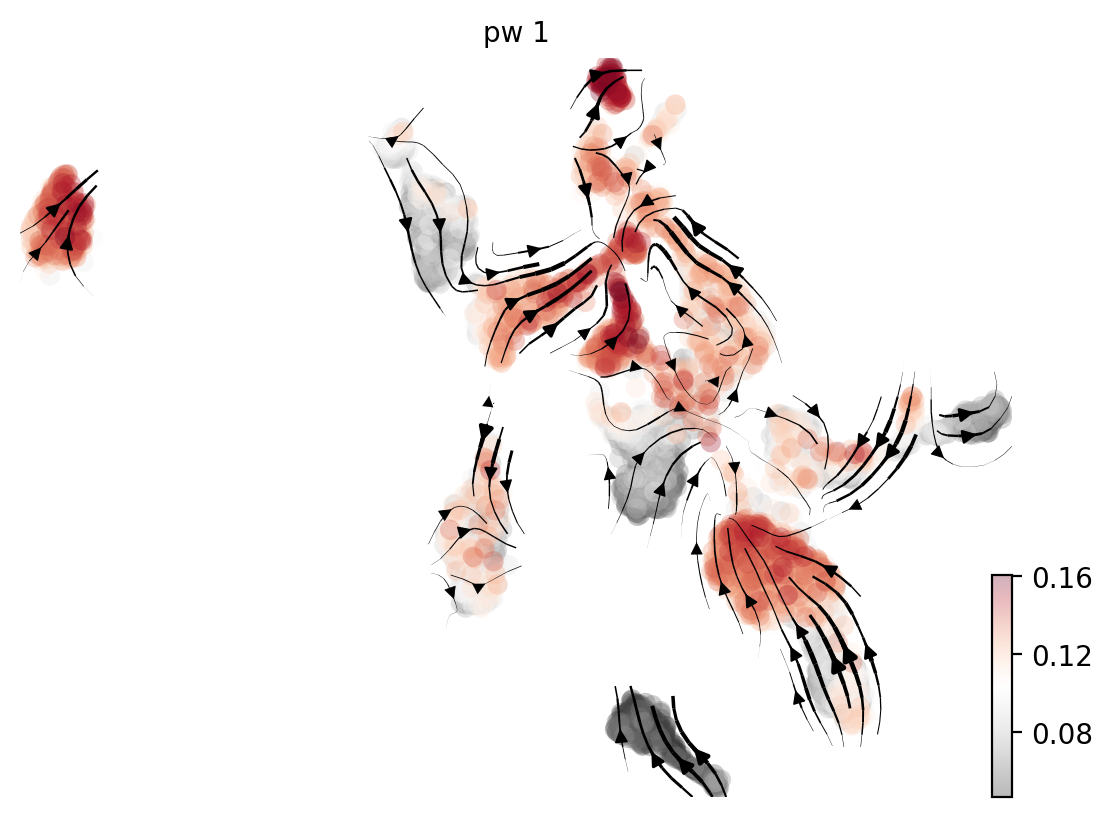

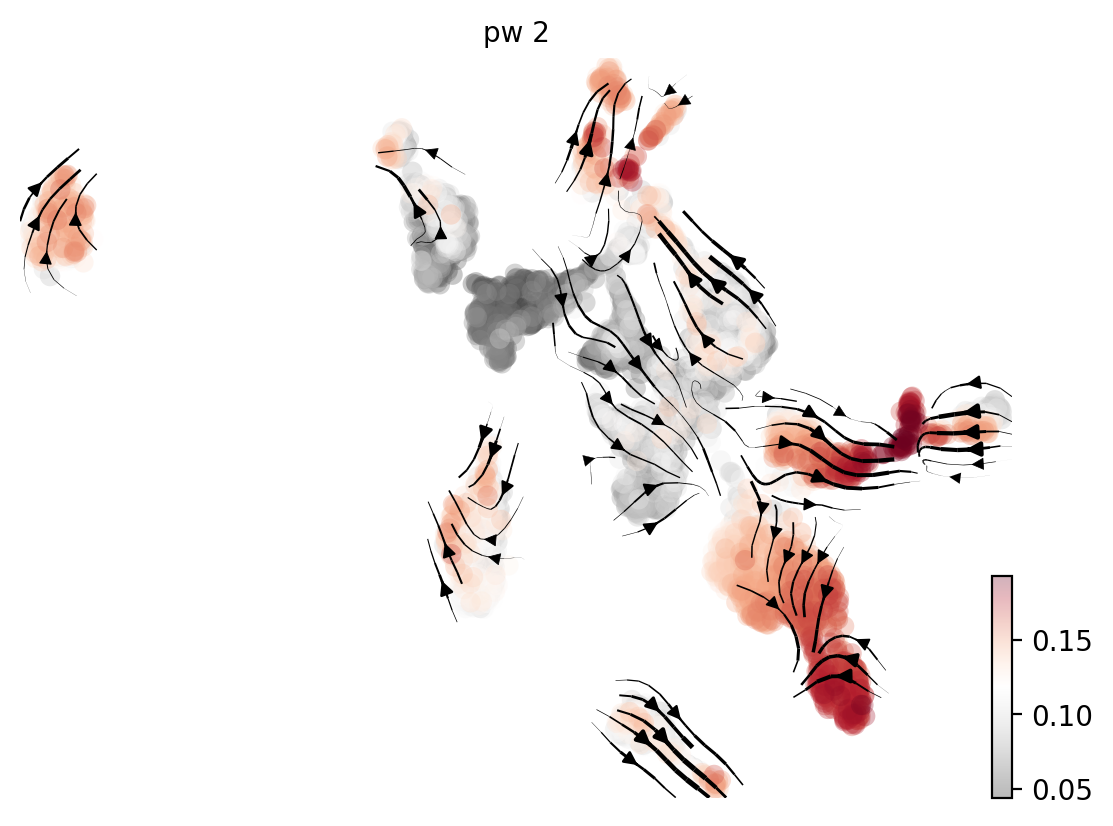

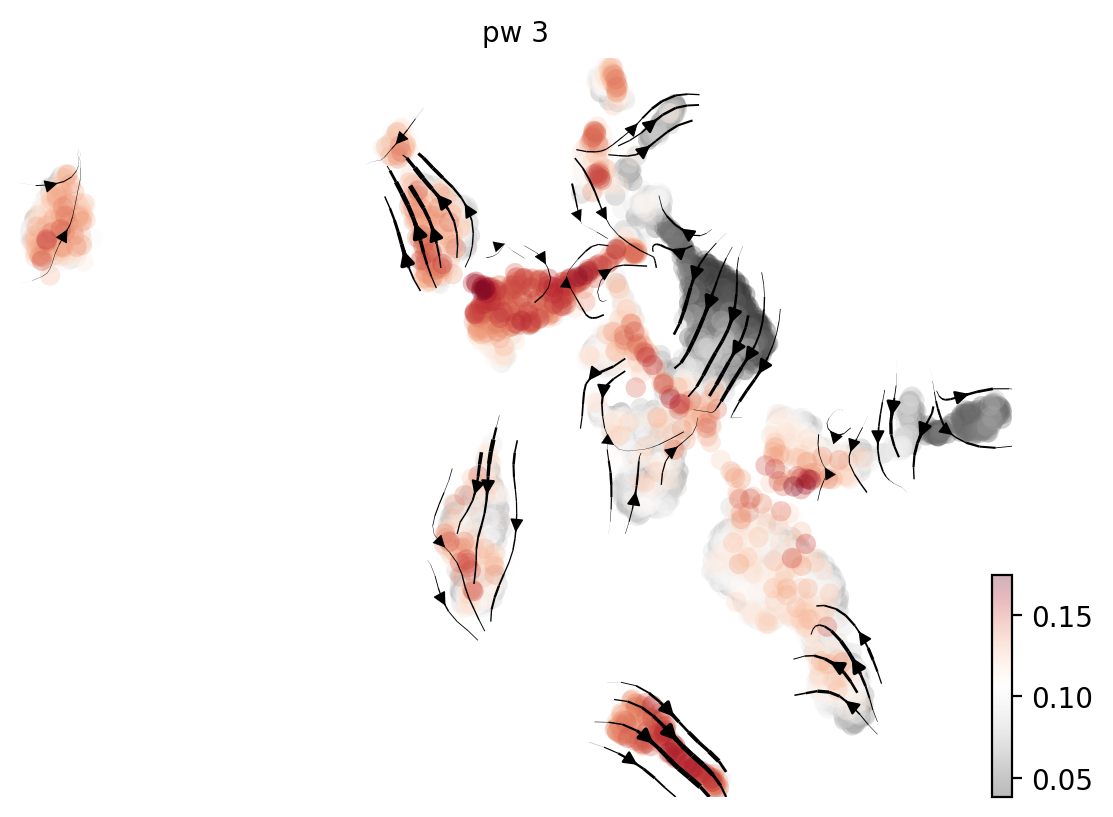

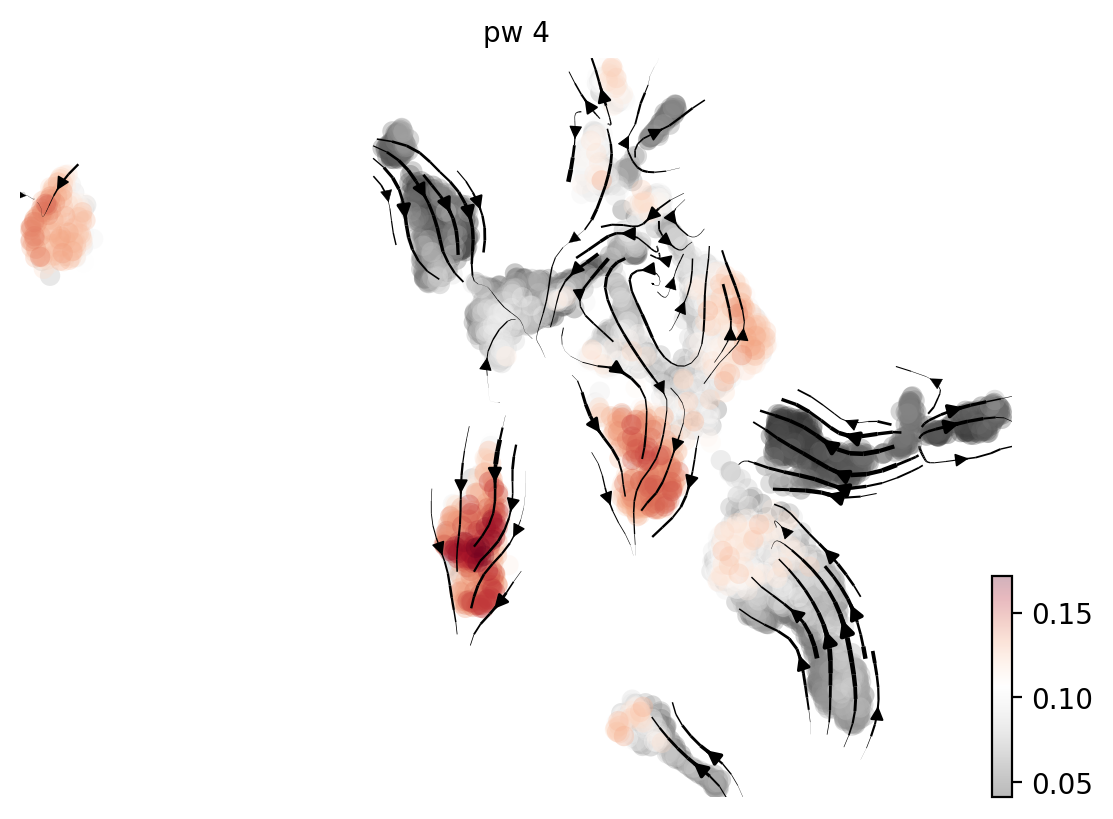

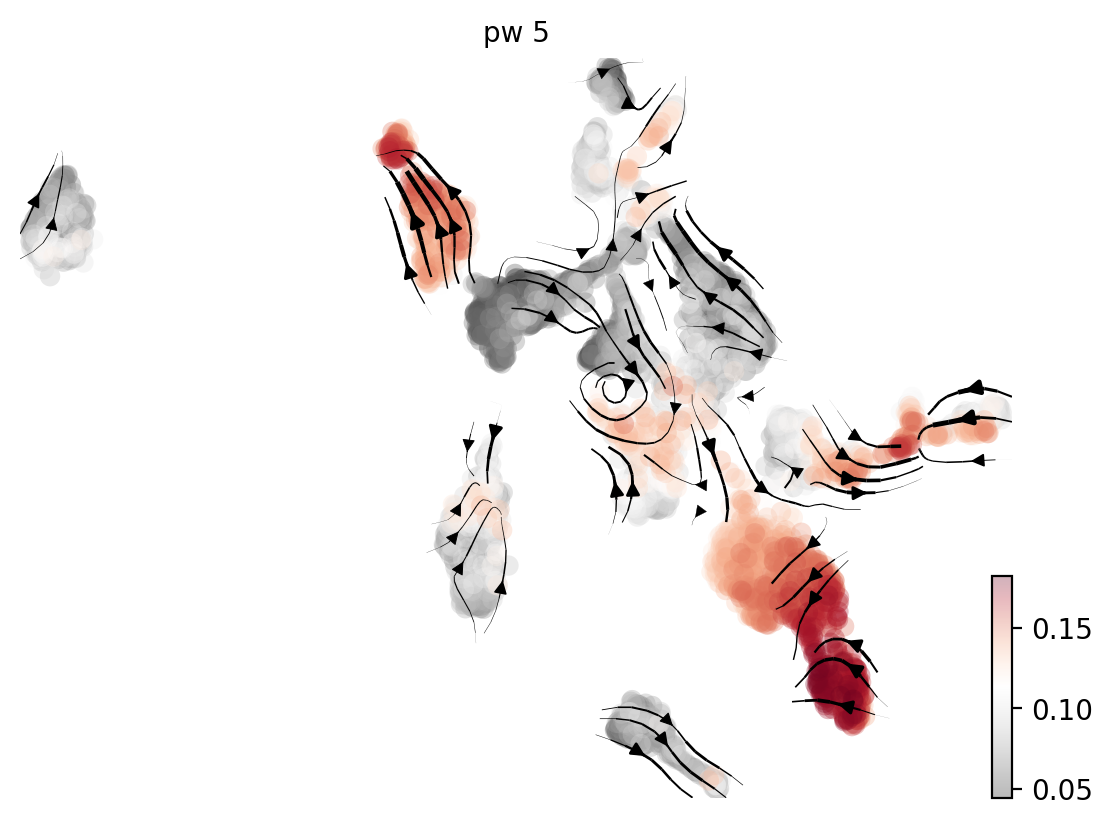

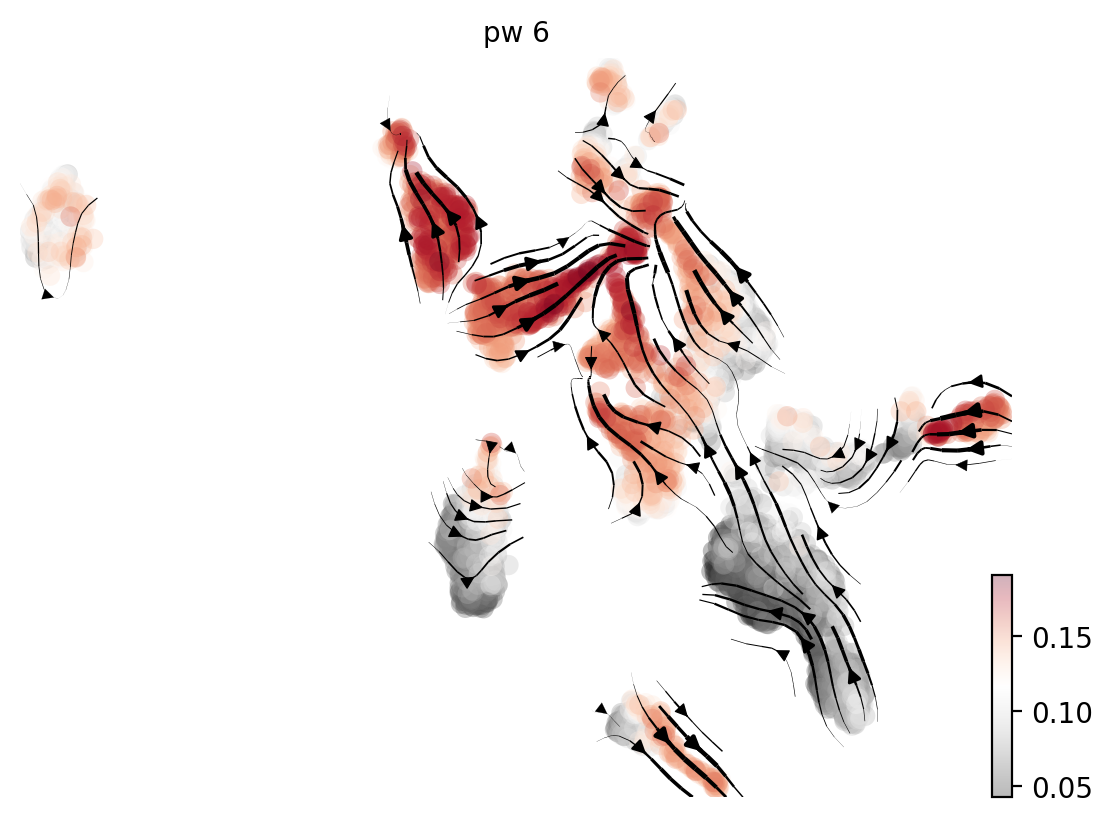

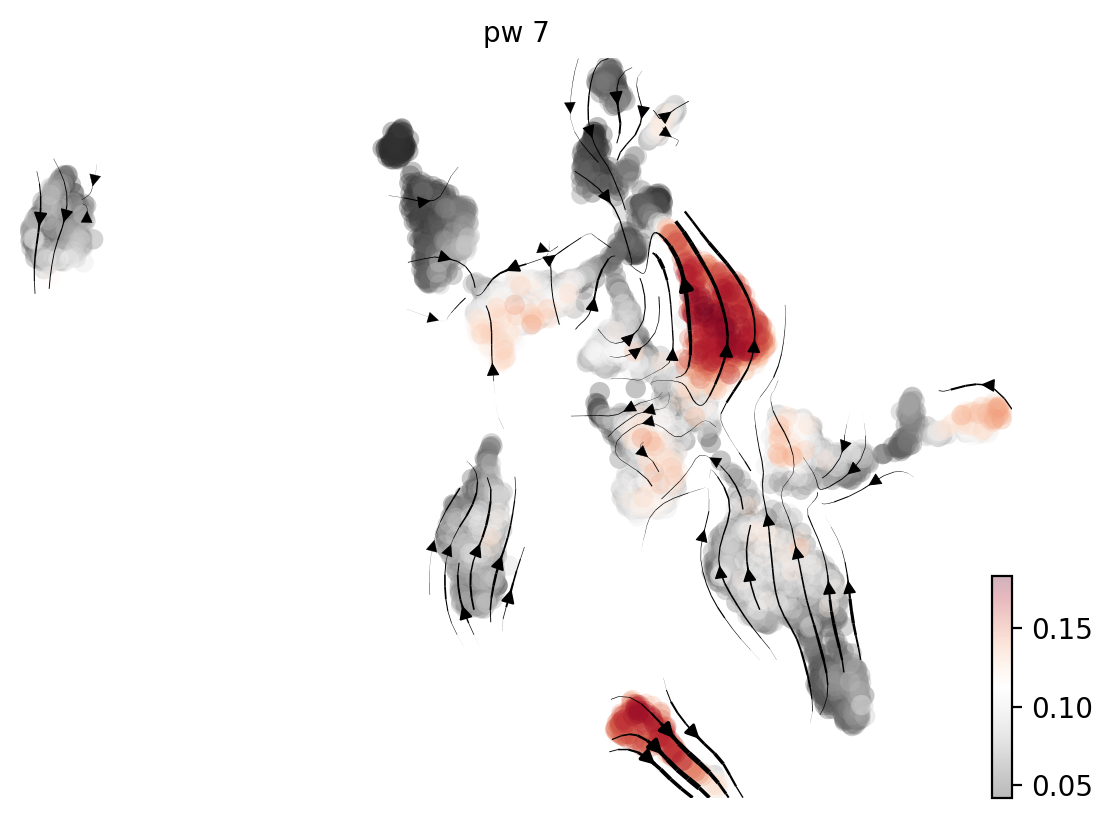

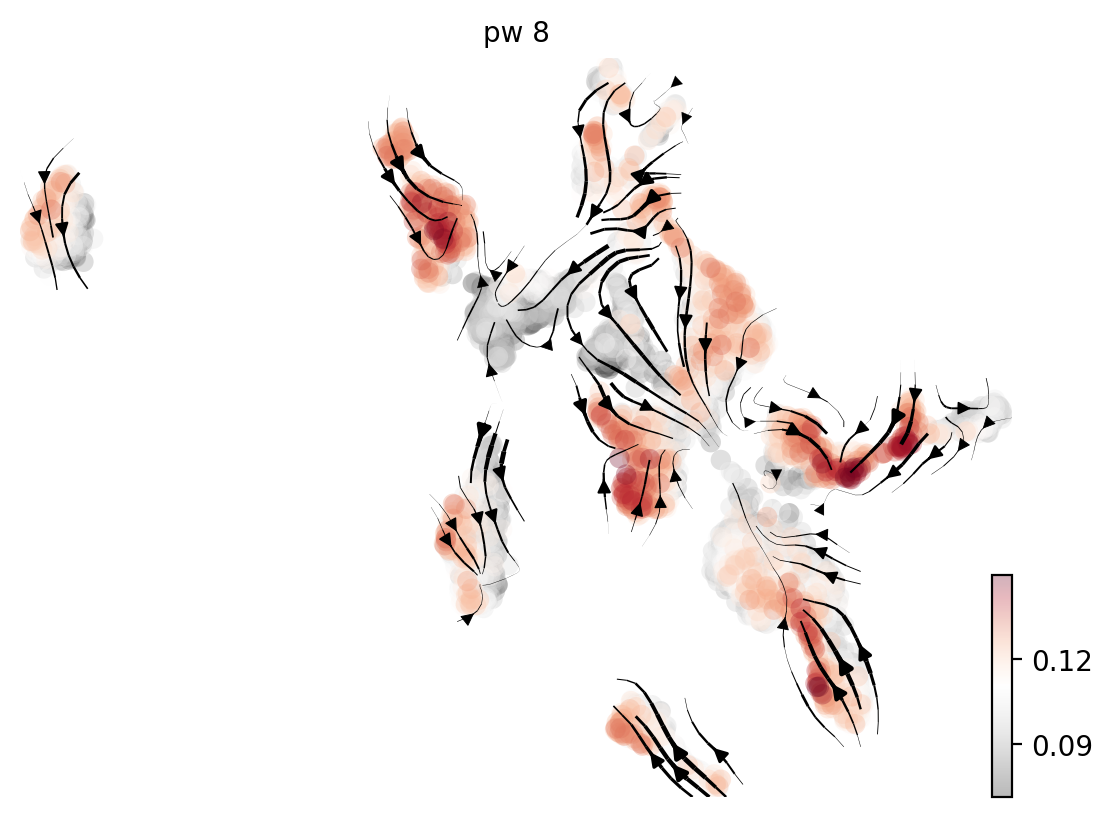

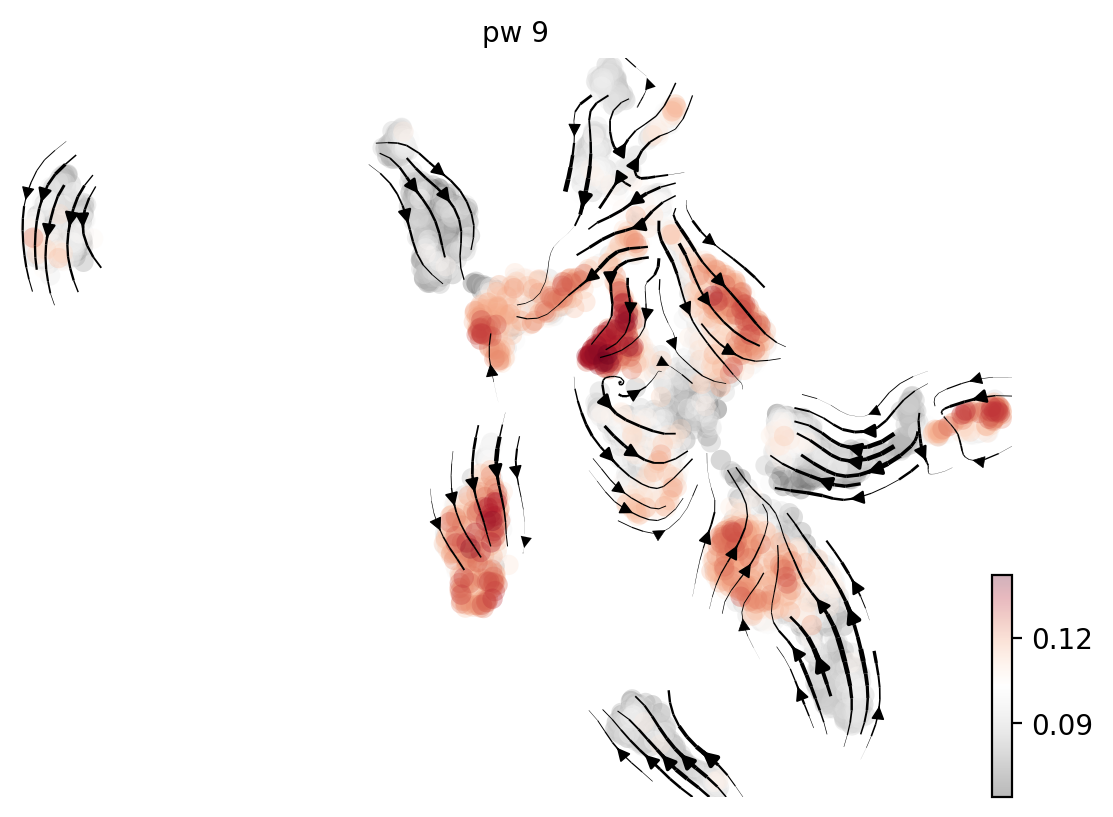

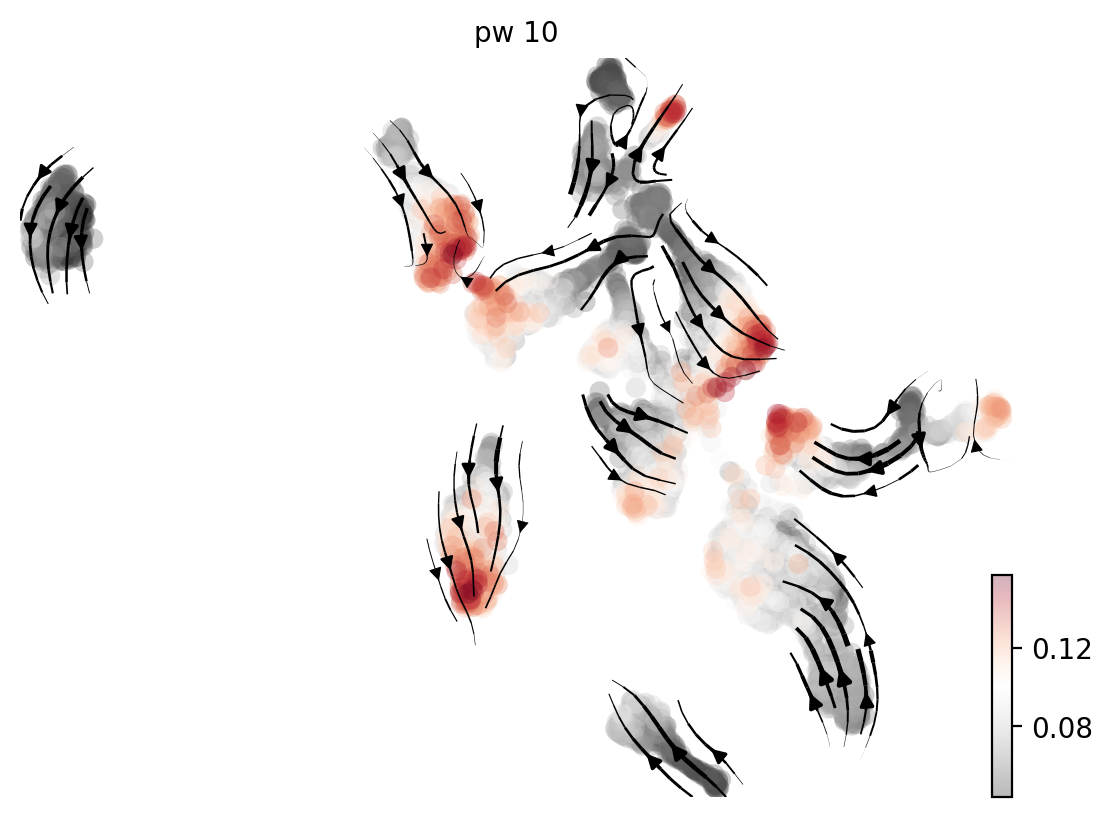

In [16]:
# Latent space UMAP
for i in range(n_dynamics):
    sc.pp.neighbors(adata_VAPOR, use_rep='X_VAPOR', random_state=0, n_neighbors=n_neighbors)
    scv.tl.velocity_graph(adata_VAPOR, vkey=f'v_psi{i+1}', xkey='vapor')
    ax = scv.pl.velocity_embedding_stream(
        adata_VAPOR,
        basis='umap',
        vkey=f'v_psi{i+1}',
        color=[f'pw_{i+1}'],
        cmap='RdGy_r',
        n_neighbors=50,
        dpi=200,
        show=False,
    )
    ax.get_figure().savefig(f'./plots/components_{i+1}.svg')


In [17]:
# # GEX space UMAP
# for i in range(n_dynamics):
#     sc.pp.neighbors(adata_VAPOR, use_rep='X_VAPOR', random_state=0, n_neighbors=n_neighbors)
#     scv.tl.velocity_graph(adata_VAPOR, vkey=f'v_psi{i+1}', xkey='vapor')
#     scv.pl.velocity_embedding_stream(
#         adata_VAPOR,
#         basis='gex_umap',
#         vkey=f'v_psi{i+1}',
#         color=[f'pw_{i+1}'],
#         cmap='RdGy_r',
#         show=True,
#         n_neighbors=50,
#         dpi=200
#     )


## Prioritizations

In [18]:
adata_VAPOR = vapor.inference.directional_gene_scores_jvp_progress(
    trained_model,
    adata_VAPOR,
    batch_size=256,
    alpha = 1.0,
    tau_quantile = 0.6,)


Directional gene scoring: 100%|██████████| 235/235 [00:03<00:00, 69.79it/s]


In [19]:
import gseapy as gp

libs = gp.get_library_name(organism='Human')
[x for x in libs if x.startswith('GO_')][:50]


['GO_Biological_Process_2021',
 'GO_Biological_Process_2023',
 'GO_Biological_Process_2025',
 'GO_Cellular_Component_2021',
 'GO_Cellular_Component_2023',
 'GO_Cellular_Component_2025',
 'GO_Molecular_Function_2021',
 'GO_Molecular_Function_2023',
 'GO_Molecular_Function_2025']

In [20]:
attributions = {}
for k in adata_VAPOR.uns['vapor_directional_gene_scores']:
    reduced_attributions = adata_VAPOR.uns['vapor_directional_gene_scores'][k]['scores']
    attributions[k] = {}
    attributions[k]['scores'] = reduced_attributions @ red.components_
adata_VAPOR.uns['vapor_directional_gene_scores_inv'] = attributions

In [21]:
# TODO: Update after Jie update to upstream
enrichment_results = vapor.inference.run_enrichment(
    adata_VAPOR,
    psi_indices=None,     # all psi, or [1,2,3,...]
    gene_names=gene_names,      # default from adata_VAPOR.uns
    store_key='vapor_directional_gene_scores_inv',
    select='pos',         # or "neg", or "both"
    top_n=150,            # top 100 genes
    organism='Human',
    gene_sets=(
        'GO_Biological_Process_2025',
        'GO_Cellular_Component_2025',
    ),
)


Running enrichment for psi1_pos (150 genes)


Running enrichment for psi2_pos (150 genes)
Running enrichment for psi3_pos (150 genes)
Running enrichment for psi4_pos (150 genes)
Running enrichment for psi5_pos (150 genes)
Running enrichment for psi6_pos (150 genes)
Running enrichment for psi7_pos (150 genes)
Running enrichment for psi8_pos (150 genes)
Running enrichment for psi9_pos (150 genes)
Running enrichment for psi10_pos (150 genes)


In [22]:
# TODO: Currently, enrichment_results is empty

Saved: ./plots/enrich_pos.pdf


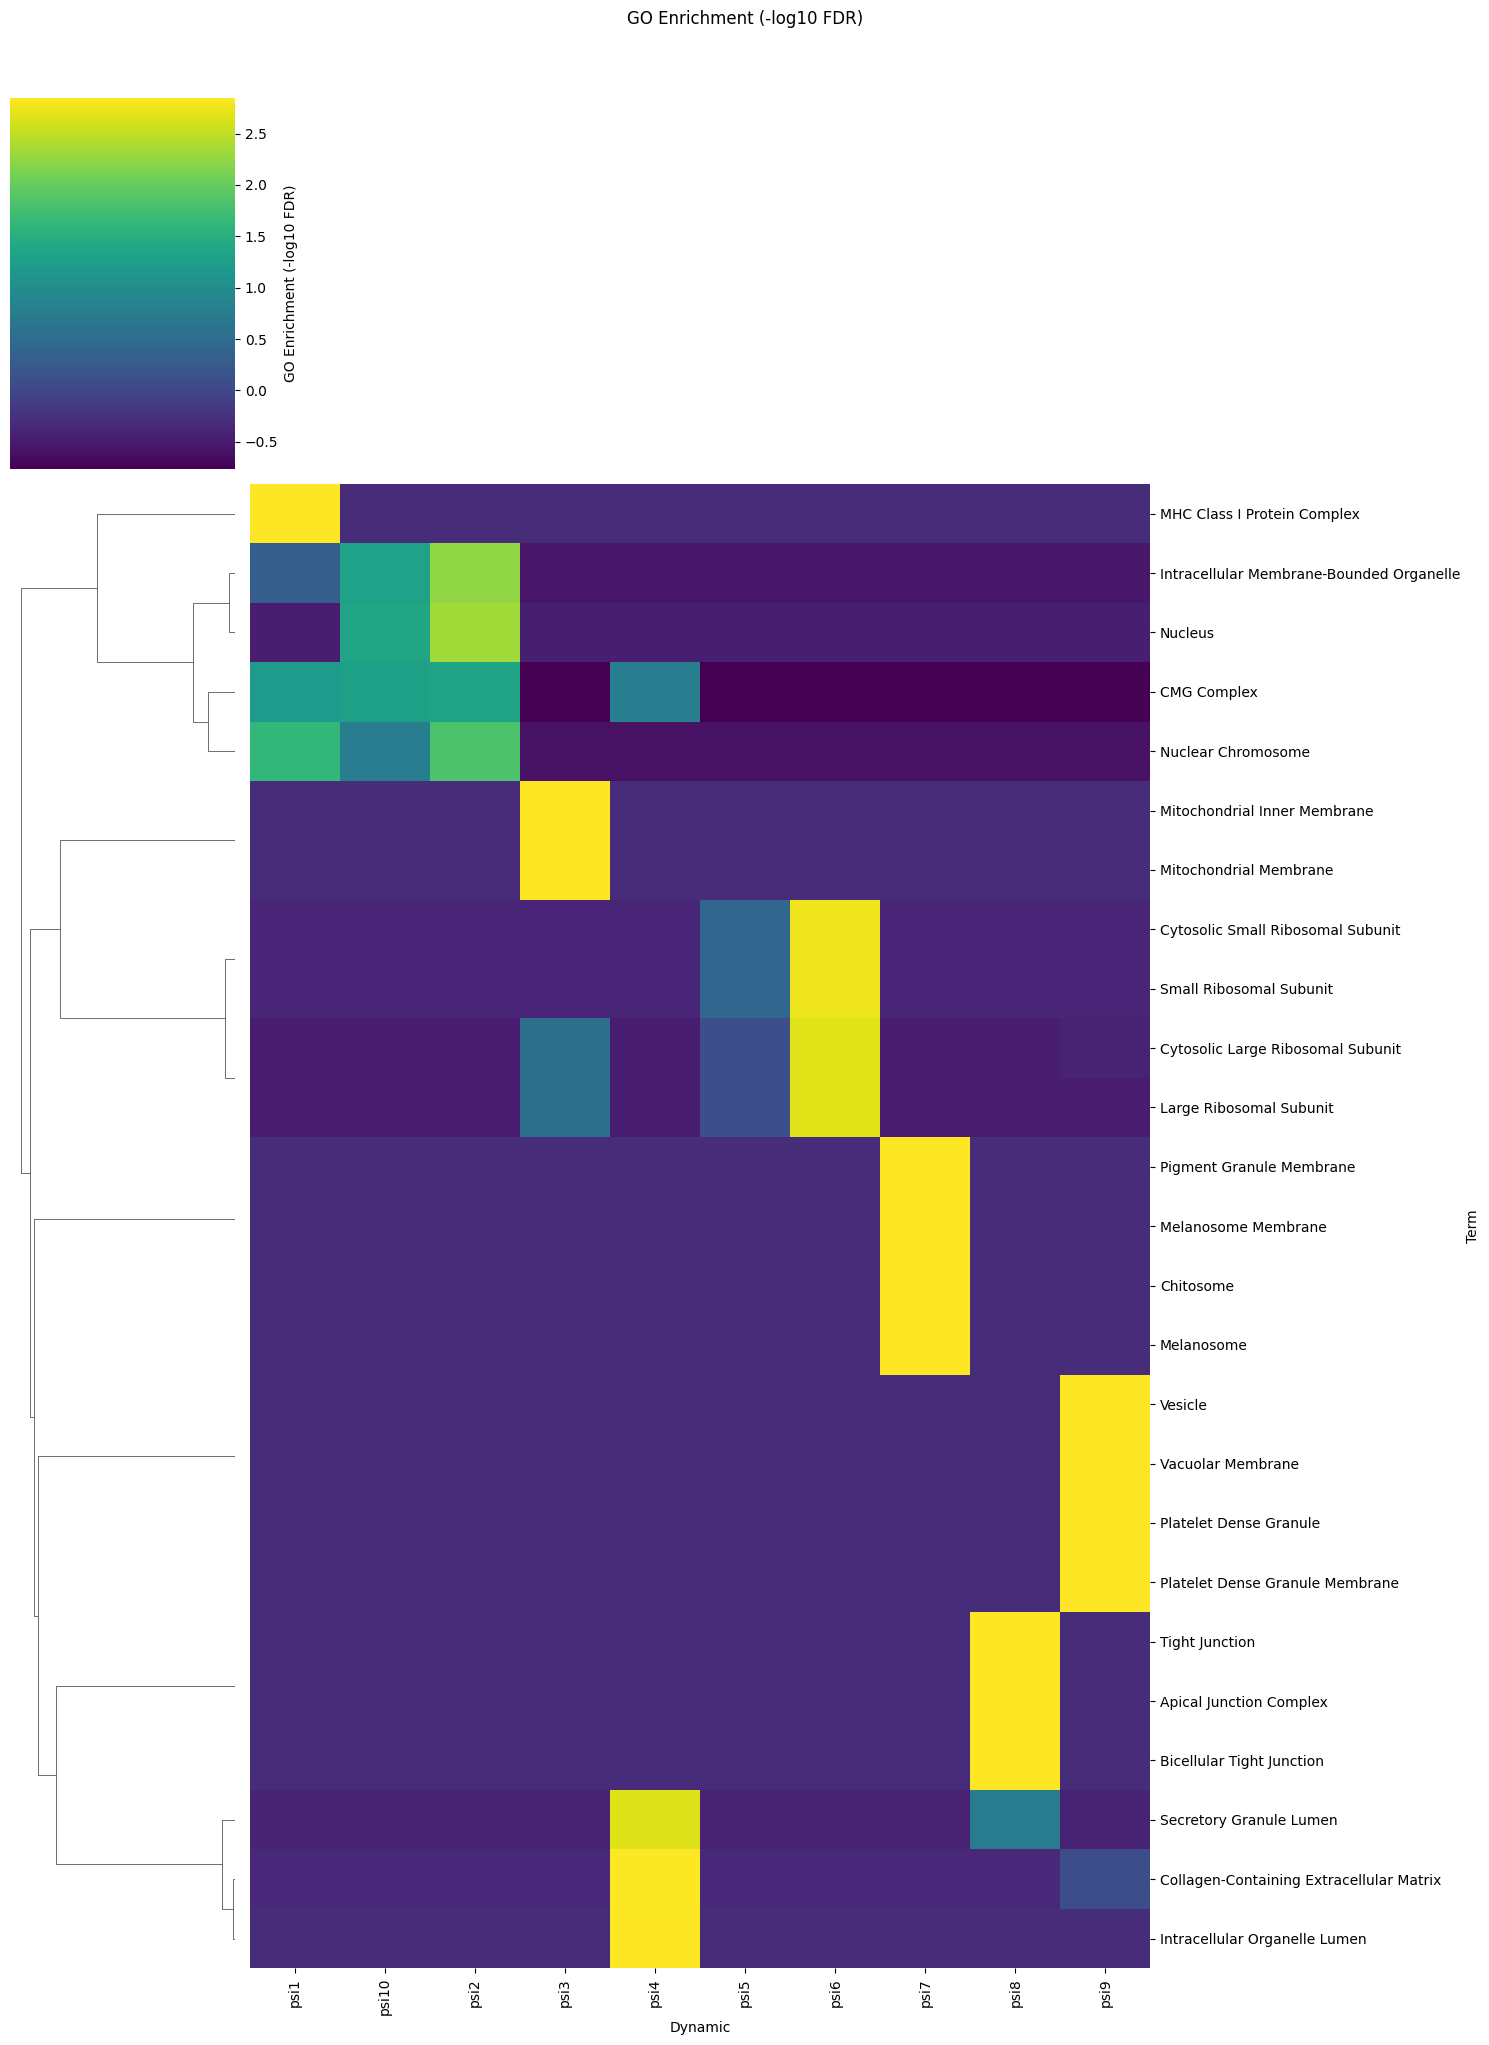

In [23]:
mat = vapor.inference.build_heatmap_mats(enrichment_results,
                                         top_n=7 # top n enriched terms
                                         )
for k, v in mat.items():
    vapor.inference.plot_heatmap(v, 'GO Enrichment (-log10 FDR)',
                                 figsize=(15, 20),cmap='viridis', cluster=True, col_cluster=False,
                                 zscore_rows=True, save=f'./plots/enrich_{k}.pdf')
